# Attribution methods

In this notebook I perform attribution methods with the Wts and check for correlation with the sign distributions.

In [1]:
# imports

from cnn_architecture import CNN2Model
from utils import *
from load_datasets import load_and_prep_dataset

import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

2024-06-24 16:41:53.603018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis_no_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNN2Model_adapted(tf.keras.Model):
    
    # basic
    def __init__(self):
        super(CNN2Model_adapted, self).__init__()
        
        # set biases to a value that is not exactly 0.0, so they don't get handled like pruned values
        self.bias_in = tf.keras.initializers.Constant(value=0.0000000001)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),input_shape=(32, 32, 64)) # [batchsize,16,16,64]
        self.flatten = tf.keras.layers.Flatten() # [batch_size,16384]
        self.dense1 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense2 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense3 = tf.keras.layers.Dense(10, activation="softmax",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]

    #@tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        dense1_input = self.flatten(x)
        dense1_out = self.dense1(dense1_input)
        dense2_out = self.dense2(dense1_out)
        dense3_out = self.dense3(dense2_out)
        return dense3_out, dense1_out[0], dense2_out[0]

### Measure and Store Contribution Scores

In [3]:
def get_connected_neurons(layer):

    indexi = []

    for this_neuron, i in zip(layer.T, range(256)):
        this_unpruned = this_neuron[this_neuron != 0.0]
        # only include neurons that receive input
        if len(this_unpruned) > 0:
                indexi.append(i)

    return indexi
     

In [4]:
# get contribution values for neurons
def contribution_scores(test, model):

    # hyperparameters
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    # initializeing contribution scores
    c_score_1 = np.zeros(256)
    c_score_2 = np.zeros(256)

    # get the neurons that don't receive input
    indexi_connected_d1 = get_connected_neurons(model.get_weights()[4])

    # iterate through testing set and get gradients for each weight
    for x, t in tqdm(test):

        # get gradients 
        with tf.GradientTape() as tape:
            pred, dense1_out, dense2_out = model(x)
            loss = loss_function(t, pred)
        gradients = tape.gradient(loss, model.trainable_variables)

        # set gradients to zero for all pruned weights
        gradients_dense2 = tf.where(model.trainable_variables[6] == 0.0, 0.0, gradients[6])
        gradients_dense3 = tf.where(model.trainable_variables[8] == 0.0, 0.0, gradients[8])

        # compute c score for each (connected) neuron
        for i in range(256):
            if i in indexi_connected_d1:
                c_score_1[i] = c_score_1[i] + np.sum(np.abs(gradients_dense2[i]*dense1_out[i]))
            c_score_2[i] = c_score_2[i] + np.sum(np.abs(gradients_dense3[i]*dense2_out[i]))

    # remove c_scores of unconnected neurons
    c_score_1 = [c_score_1[j] for j in indexi_connected_d1]

    # normalize c_scores to values between 0 and 1
    c_score_1 = c_score_1 / np.sum(c_score_1)
    c_score_2 = c_score_2 / np.sum(c_score_2)
    
    return c_score_1, c_score_2

In [5]:
# store contribution values for each sign distribution in files
def get_and_store_c_scores(datasets, n_wts):
    train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=2, shuffle_size=512)
    model = CNN2Model_adapted()
    model(list(train_dataset)[0][0])

    for dataset in datasets:
        for i in n_wts:
            train_dataset, test_dataset = load_and_prep_dataset(dataset, batch_size=1, shuffle_size=512)
            model.load_weights(f"1b WTs/h5_format/WT_{dataset}_IMP_{i}.h5")
            c_scores_1, c_scores_2 = contribution_scores(test_dataset, model)
            np.save(f"5d Contribution scores/c_scores_dense1_{dataset}_wt{i}", np.array(c_scores_1))
            np.save(f"5d Contribution values/c_scores_dense2_{dataset}_wt{i}", np.array(c_scores_2))

In [6]:
#get_and_store_c_scores(["CIFAR","CINIC","SVHN"],range(15))

Also for RSNs:

In [7]:
def get_and_store_c_scores_RSNs(n):

    # get initialized model
    train_dataset_cifar, test_dataset_cifar = load_and_prep_dataset("CIFAR", batch_size=1, shuffle_size=512)
    train_dataset_cinic, test_dataset_cinic = load_and_prep_dataset("CINIC", batch_size=1, shuffle_size=512)
    train_dataset_svhn, test_dataset_svhn = load_and_prep_dataset("SVHN", batch_size=1, shuffle_size=512)
    model = CNN2Model_adapted()
    model(list(train_dataset_cifar)[0][0])

    for i in range(n):
        model.load_weights(f"1b WTs/h5_format/RSN_{i}.h5")

        c_scores_1_cifar, c_scores_2_cifar = contribution_scores(test_dataset_cifar, model)
        c_scores_1_cinic, c_scores_2_cinic = contribution_scores(test_dataset_cinic, model)
        c_scores_1_svhn, c_scores_2_svhn = contribution_scores(test_dataset_cifar, model)

        c_scores_1 = np.mean([c_scores_1_cifar, c_scores_1_cinic, c_scores_1_svhn],axis = 0)
        c_scores_2 = np.mean([c_scores_2_cifar, c_scores_2_cinic, c_scores_2_svhn],axis = 0)

        np.save(f"5d Contribution scores/c_scores_dense1_RSN{i}", np.array(c_scores_1))
        np.save(f"5d Contribution scores/c_scores_dense2_RSN{i}", np.array(c_scores_2))


In [8]:
#get_and_store_c_scores_RSNs(15)

### Plot the extracted Contribution scores

In [9]:
def get_coll_combi_sign_distr(n, dataset):

    # collect all the sign distributions in one huge dataFrame
    coll_combi_sign_distr = pd.DataFrame()
    for i in range(n):

        # get sign distr and contribution scores
        if dataset == "RSN":
            sign_distr = pd.read_csv(f'2b Sign distributions/RSN_{i}_sign_distr.csv')
            c_scores1 = np.load(f"5d Contribution scores/c_scores_dense1_RSN{i}.npy")
            c_scores2 = np.load(f"5d Contribution scores/c_scores_dense2_RSN{i}.npy")
        else:
            sign_distr = pd.read_csv(f'2b Sign distributions/{dataset}_IMP_{i}_sign_distr.csv')
            c_scores1 = np.load(f"5d Contribution scores/c_scores_dense1_{dataset}_wt{i}.npy")
            c_scores2 = np.load(f"5d Contribution scores/c_scores_dense2_{dataset}_wt{i}.npy")


        # combine sign distr and contribution scores
        c_scores1 = pd.Series(c_scores1, name="c_scores")
        c_scores2 = pd.Series(c_scores2, name="c_scores")
        c_scores = pd.concat([c_scores1,c_scores2], axis=0)
        c_scores= c_scores.reset_index(drop=True)
        sign_distr_combi = pd.concat([sign_distr,c_scores], axis=1)

        # add to collective sign distr
        coll_combi_sign_distr = pd.concat([coll_combi_sign_distr, sign_distr_combi])

    return coll_combi_sign_distr

In [69]:
# collect statistics for contribution value of each cluster

def plot_and_store_coll_combi_sign_distr():

    for dataset in ["CIFAR","CINIC","SVHN","RSN"]:

        coll_combi_sign_distr = get_coll_combi_sign_distr(15, dataset)

        # seperate the dataframe by layer
        coll_combi_sign_distr1 = coll_combi_sign_distr[coll_combi_sign_distr["layer"]=="dense1"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out", "c_scores"]]
        coll_combi_sign_distr2 = coll_combi_sign_distr[coll_combi_sign_distr["layer"]=="dense2"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out", "c_scores"]]

        # make plots
        plot_1 = sns.PairGrid(coll_combi_sign_distr1.loc[:, coll_combi_sign_distr1.columns != "c_scores"], height=1.7)
        #plot_1.map_lower(sns.scatterplot, data=coll_combi_sign_distr1, alpha = 0.4, palette=sns.light_palette("#421B45", as_cmap=True), color="#421B45", hue ="c_scores", legend="brief")
        plot_1.map_lower(sns.scatterplot, data=coll_combi_sign_distr1, alpha = 0.2, palette=sns.cubehelix_palette(rot=.2, as_cmap=True), color="#421B45", hue ="c_scores", legend="brief")
        plot_1.map_upper(sns.kdeplot, fill=True, cmap="rocket")
        plot_1.map_diag(sns.histplot, color="#A3195B", element="step")
        plot_1.add_legend()

        plot_2 = sns.PairGrid(coll_combi_sign_distr2.loc[:, coll_combi_sign_distr2.columns != "c_scores"], height=1.7)
        #plot_2.map_lower(sns.scatterplot, data=coll_combi_sign_distr2, alpha = 0.4, palette=sns.light_palette("#421B45", as_cmap=True), color="#421B45", hue ="c_scores", legend="brief")
        plot_2.map_lower(sns.scatterplot, data=coll_combi_sign_distr2, alpha = 0.2, palette=sns.cubehelix_palette(rot=.2, as_cmap=True), color="#421B45", hue ="c_scores", legend="brief")
        plot_2.map_upper(sns.kdeplot, fill=True, cmap="rocket")
        plot_2.map_diag(sns.histplot, color="#A3195B", element="step")
        plot_2.add_legend()

        # store plots
        plot_1.savefig(f"5d Contribution scores/{dataset}_dense1_all_sign_distr_combi.png")
        plot_2.savefig(f"5d Contribution scores/{dataset}_dense2_all_sign_distr_combi.png")

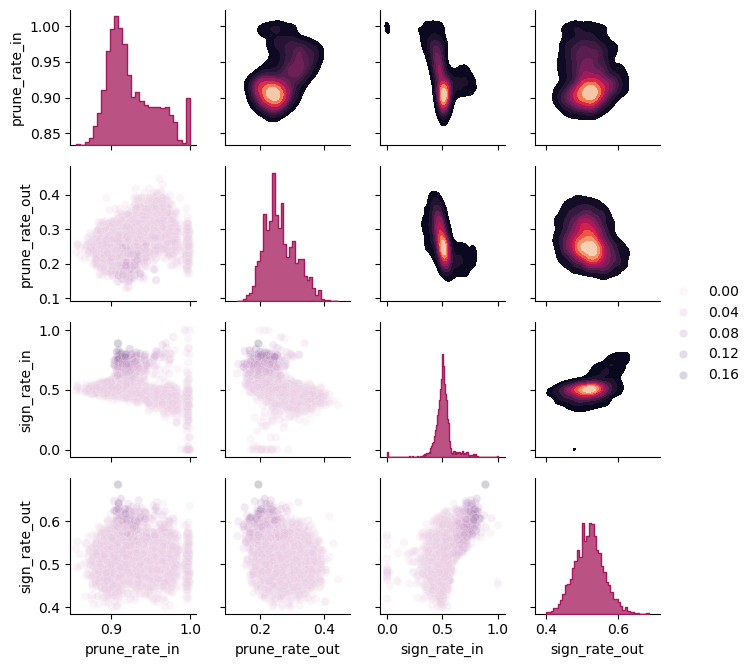

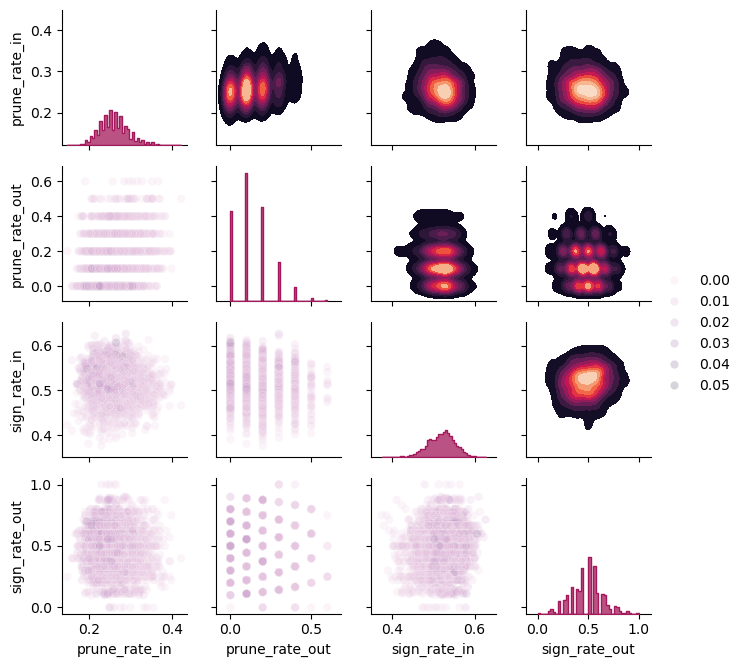

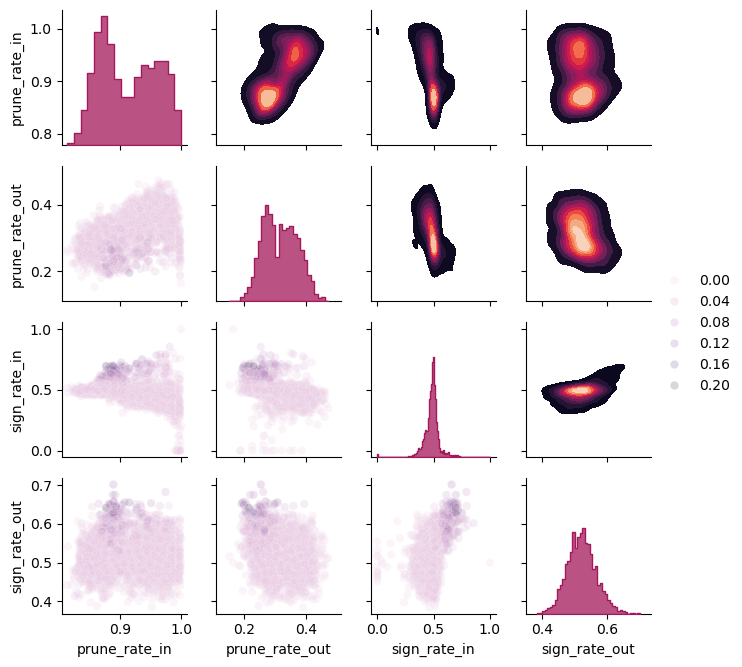

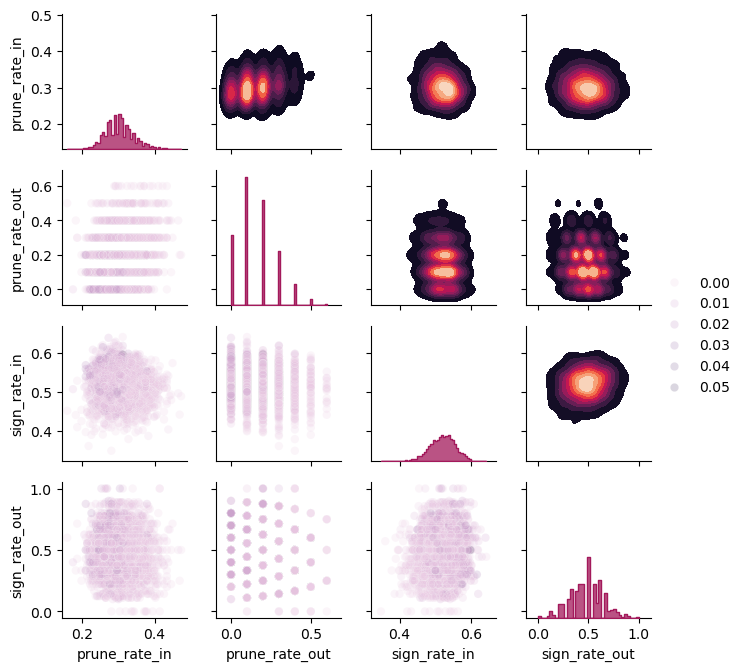

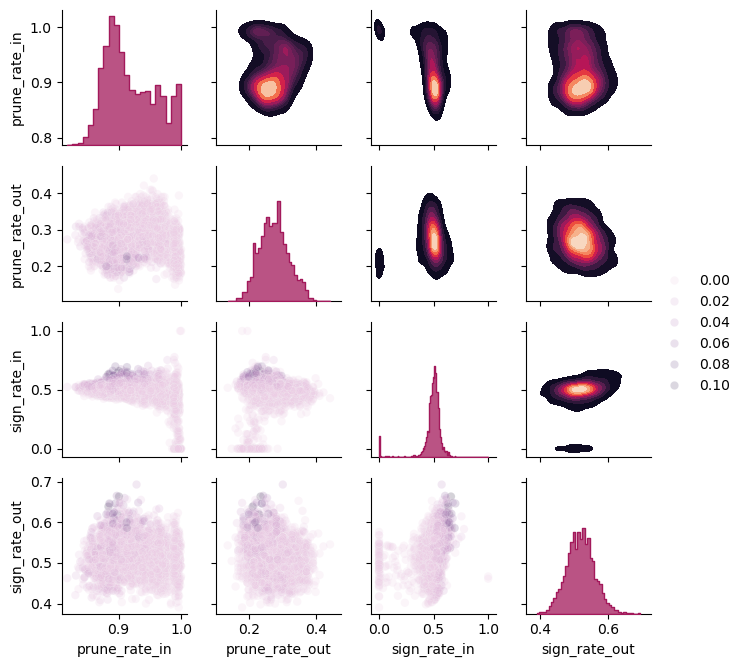

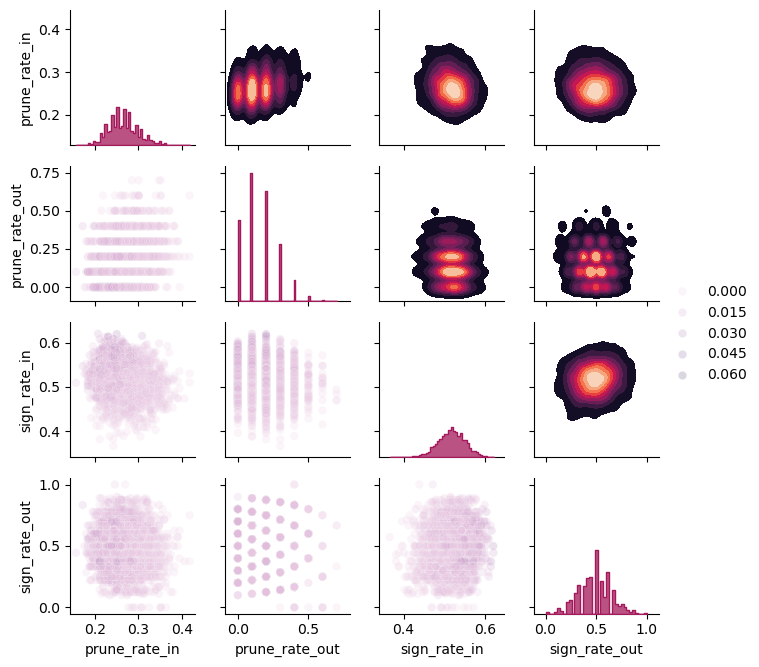

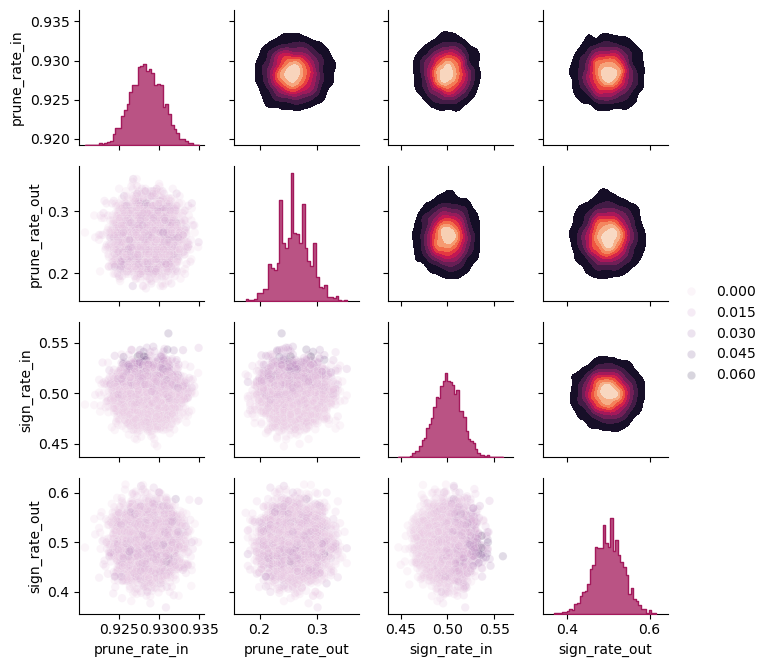

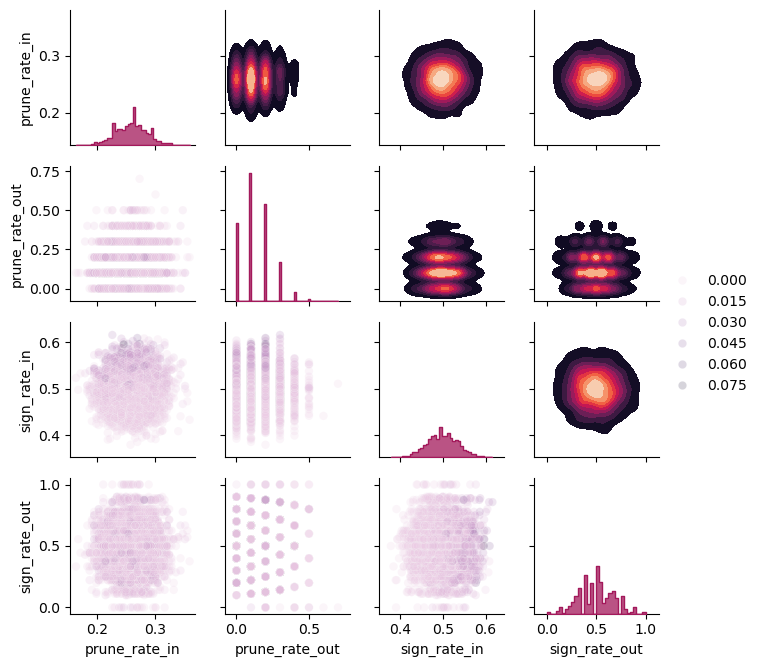

In [70]:
plot_and_store_coll_combi_sign_distr()

In [55]:
# plot the c-score contribution rows together for readability

def get_and_store_2d_plots():

    for layer in ["dense1", "dense2"]:
        fig, axes = plt.subplots(4, 5, figsize=(15,10,5), constrained_layout=True)

        # process dataframe
        for r, dataset in enumerate(["CIFAR","CINIC","SVHN","RSN"]):

            coll_combi_sign_distr = get_coll_combi_sign_distr(15, dataset)
            coll_combi_sign_distr = coll_combi_sign_distr[coll_combi_sign_distr["layer"]== layer]

            for c, variable in enumerate(["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out", "c_scores"]):

                if c == 4:
                    # plot c_score
                    plot = sns.kdeplot(data=coll_combi_sign_distr, y ='c_scores',legend=False,fill=True, ax=axes[r,c])
                    axes[r,c].set(xlabel=None)

                else:
                    # plot scatterplot
                    plot = sns.scatterplot(data=coll_combi_sign_distr, x = variable, y = "c_scores", alpha=0.1, ax=axes[r,c])
                    #plot = sns.kdeplot(data=coll_combi_sign_distr, x = variable, y = "c_scores", fill=False,ax=axes[r,c])
                    axes[r,c].set_ylabel("contribution scores")
                    axes[r,c].set(xlabel=None)

        # naming rows and cols
        pad = 10
        for ax, col in zip(axes[0], ["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out", "c_scores"]):
            ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                        xycoords='axes fraction', textcoords='offset points',
                        size='large', ha='center', va='baseline')
        for ax, row in zip(axes[:,0], ["CIFAR","CINIC","SVHN","RSN"]):
            ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center')
        
        # print and store plot
        plt.show()
        fig.savefig(f"5d Contribution scores/2dimensional_plots_combi_sign_distr_all_{layer}.png")

In [60]:
get_and_store_2d_plots()

TypeError: Bbox.from_bounds() takes 4 positional arguments but 5 were given